<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/AdaBoostnXGBoost_IMPrj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls       

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

W0812 07:03:25.480674 140260128122752 deprecation.py:323] From <ipython-input-2-00b17d59170f>:10: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0812 07:03:25.491857 140260128122752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.621066857000187
GPU (s):
0.9189344709993748
GPU speedup over CPU: 3x


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display
pd.options.display.max_columns=None

import matplotlib

import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingClassifier

##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.metrics import recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

df = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/bank-additional-full_prj.csv')

df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
# Separating with continuous and categorical variables.

#X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

cont_df = df[X_cont]
cat_df = df[X_cat]

# Creating dummyX variable dataframe from categorical variables.

X = cont_df.join(pd.get_dummies(cat_df))
y = df.iloc[:, 20].replace(('yes', 'no'), (1, 0))

In [0]:
X.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'euribor3m', 'nr.employed', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_

In [0]:
mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

allabel_df = df
label_df = df.drop('y', axis=1)
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))



In [0]:
allabel_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [0]:
label_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [0]:
y.shape

(41188,)

In [0]:
label_df.shape

(41188, 20)

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values
'''
##Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)
'''
#Choose all predictors except target & IDcols
#predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20,81,100)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier
                        (
                            learning_rate=0.1, min_samples_split=500, min_samples_leaf=100, max_depth=10, max_features='sqrt', subsample=0.8
                            , random_state=10), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5
                        )
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=10,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=100,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  p

In [0]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.50014038]),
  'mean_score_time': array([0.02942657]),
  'mean_test_score': array([0.94200998]),
  'param_n_estimators': masked_array(data=[20],
               mask=[False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20}],
  'rank_test_score': array([1], dtype=int32),
  'split0_test_score': array([0.94423508]),
  'split1_test_score': array([0.94820958]),
  'split2_test_score': array([0.94199604]),
  'split3_test_score': array([0.93549807]),
  'split4_test_score': array([0.94011111]),
  'std_fit_time': array([0.48147975]),
  'std_score_time': array([0.0085394]),
  'std_test_score': array([0.0042284])},
 {'n_estimators': 20},
 0.9420099770570713)

 {'n_estimators': 80}, 0.9399256128653919) -- Learning rate 0.1, MinSampleLeafs=50; max_depth=8
 
 {'n_estimators': 90},0.9403135418595883) -- Learning rate 0.1, MinSampleLeafs=100; max_depth=10

{'n_estimators': 20}, 0.9420099770570713) -- Learning rate 0.1; n_estms(20,81,100)

In [0]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([1.10620756, 1.11272612, 1.00831447, 0.97083864, 0.97258277,
         1.54061131, 1.3715837 , 1.28013463, 1.24343634, 1.20788093,
         2.01544328, 1.6988512 , 1.53840413, 1.47528625, 1.38741288,
         2.46607857, 2.05343714, 1.88427744, 1.67188363, 1.58618073,
         2.91285424, 2.3288775 , 2.03439164, 1.81806269, 1.74092307,
         3.33239536, 2.48813615, 2.11836905, 1.97970867, 1.63580284]),
  'mean_score_time': array([0.02244668, 0.02239451, 0.02463422, 0.02604084, 0.02592664,
         0.02684884, 0.02780452, 0.02587872, 0.02820258, 0.03372827,
         0.03244319, 0.03036013, 0.03383522, 0.02884469, 0.03598781,
         0.03336725, 0.03520131, 0.03039174, 0.03067951, 0.03041158,
         0.03618646, 0.03585987, 0.03258524, 0.03272066, 0.03376198,
         0.03747149, 0.03818607, 0.03438058, 0.03197193, 0.02645202]),
  'mean_test_score': array([0.93738003, 0.93837758, 0.93775835, 0.93737943, 0.93663586,
         0.94310532, 0.9416951 , 0.9404587 ,

 {'max_depth': 15, 'min_samples_split': 200},
 0.9460916140457403)

In [0]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=20,max_depth=15,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([1.72693772, 1.58387008, 1.54879265, 1.46255541, 1.44013572,
         1.33873143, 1.70208116, 1.6160233 , 1.55619717, 1.45295296,
         1.37908168, 1.33336215, 1.67493258, 1.59908094, 1.47066026,
         1.46176724, 1.40870218, 1.36564565, 1.67107077, 1.56885362,
         1.47003484, 1.4381062 , 1.41255255, 1.33037434, 1.68096695,
         1.55745034, 1.47322621, 1.41438646, 1.39188151, 1.01322112]),
  'mean_score_time': array([0.03210969, 0.0364697 , 0.03210454, 0.03181524, 0.03181052,
         0.03007598, 0.03236098, 0.03367658, 0.03399858, 0.03026214,
         0.03293805, 0.0355979 , 0.03097401, 0.02960038, 0.02865853,
         0.03171253, 0.02626448, 0.02969742, 0.02883534, 0.02896204,
         0.03156452, 0.02879558, 0.03373146, 0.03094196, 0.03418646,
         0.03421149, 0.03527241, 0.03016381, 0.02753763, 0.02731004]),
  'mean_test_score': array([0.9414403 , 0.93943114, 0.93782888, 0.93811599, 0.93691209,
         0.93610728, 0.94108382, 0.93894293,

In [0]:
def modelfit(alg, dtrain, dtest, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, dtest)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, dtest, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtest, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtest, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

In [0]:
predictors = X_train.columns
print (predictors)
#modelfit(gsearch3.best_estimator_, y_train, y_test)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')



Model Report
Accuracy : 0.9083
AUC Score (Train): 0.945946
CV Score : Mean - 0.9363128 | Std - 0.007637346 | Min - 0.9256457 | Max - 0.9451055


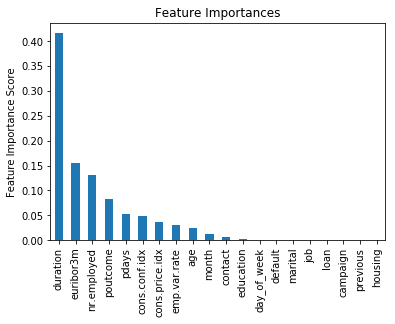

In [0]:
modelfit(gsearch3.best_estimator_, X_test, y_test)

<font color=brown size=5>
XGBoost Starts here

<font color=green size=1>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [0]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [0]:
df = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/bank-additional-full_prj.csv')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
# Separating with continuous and categorical variables.

#X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

cont_df = df[X_cont]
cat_df = df[X_cat]

# Creating dummyX variable dataframe from categorical variables.

X = cont_df.join(pd.get_dummies(cat_df))
y = df.iloc[:, 20].replace(('yes', 'no'), (1, 0))

In [0]:
mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

allabel_df = df
label_df = df.drop('y', axis=1)
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

"\n#Choose all predictors except target & IDcols\n#predictors = [x for x in train.columns if x not in [target, IDcol]]\nparam_test1 = {'n_estimators':range(20,81,100)}\ngsearch1 = GridSearchCV(estimator = GradientBoostingClassifier\n                        (\n                            learning_rate=0.1, min_samples_split=500, min_samples_leaf=100, max_depth=10, max_features='sqrt', subsample=0.8\n                            , random_state=10), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5\n                        )\ngsearch1.fit(X_train,y_train)\n"

In [0]:
def modelfit_xgb(alg, dtrain, dtest, opt, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
  if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(data=dtrain, label=dtest)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', 
                      early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(dtrain, dtest, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtest, dtrain_predictions))
    print ("AUC Score (",opt,"): %f" % metrics.roc_auc_score(dtest, dtrain_predprob))
    
                    
    feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    return dtrain_predictions,dtrain_predprob

<font color=red size=4>
Trail 1: Fix learning rate and number of estimators for tuning tree-based parameters

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy : 0.9356
AUC Score ( Train ): 0.967257


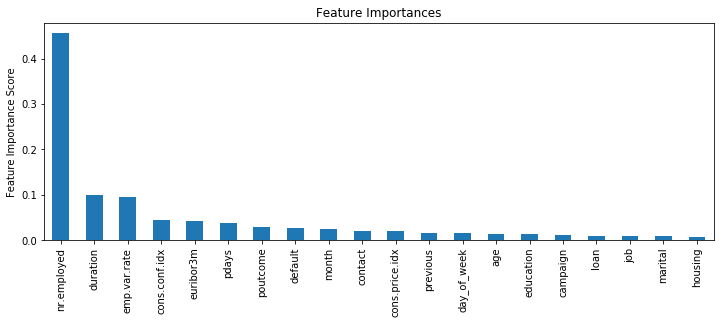

In [0]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
#modelfit_xgb(xgb1, Xtrain, ytrain)
preds, predprbs = modelfit_xgb(xgb1, X_train, y_train, "Train")

<font color=green size=3> 
Performance: Model Report
Accuracy : 0.9385
AUC Score ( Train ): 0.969116; Parameters: n_estimator ran till 150<br>
<font color=brown size=3> 
Model Report
Accuracy : 0.9356
AUC Score ( Train ): 0.967257; Parameters: n_estimators set to 250 but iterations stopped at 131. Hence, this seem a good number of iterations for learning rate 0.1. <br>
<font color=blue size=3> 
Reduce learning rate by half and increase the iterations to 500 to check the Performance: Model Report
Accuracy : 0.9379
AUC Score ( Train ): 0.968151; Parameter n_estimator stopped at 280 even thought setup was 500. <br>
<font color=red size=3> 
Setting learning rate to 0.01 and retain n_estimators to 500; Performance Deterioated. Model Report
Accuracy : 0.9263
AUC Score ( Train ): 0.957938; Parameter n-estimator was run till the end. <br>
<font color=brown size=3> 
N-estimator setup=1500; Performance: Model Report
Accuracy : 0.9368
AUC Score ( Train ): 0.967197 <br>
<font color=green size=5> 
Best Parameters are n-estimators=250 with learning rate 0.1

In [0]:
print("Train Predictions -- > ", preds, ';  Length -- > ', len(preds))
print("Train Predic Probas  -- > ", predprbs, ';  Length -- > ', len(predprbs))

xgb1.evals_result

Train Predictions -- >  [0 0 0 ... 0 0 0] ;  Length -- >  28831
Train Predic Probas  -- >  [3.6146361e-01 2.8854402e-04 1.9856906e-03 ... 7.0930325e-04 5.2913919e-04
 1.6217612e-04] ;  Length -- >  28831


<bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=131, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)>

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Model Report
Accuracy : 0.9519
AUC Score ( Test ): 0.979137


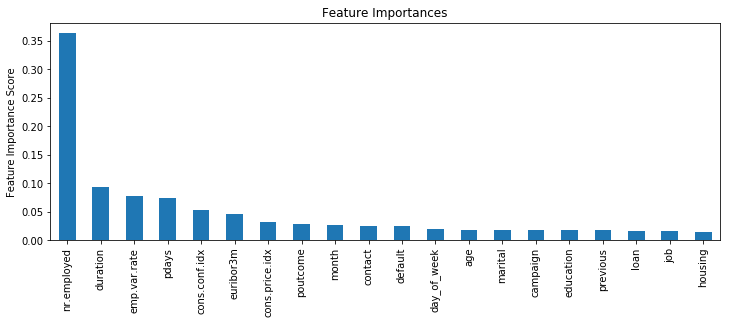

In [0]:
preds, predprbs = modelfit_xgb(xgb1, X_test, y_test, "Test")

Model Report
Accuracy : 0.9519
AUC Score ( Test ): 0.979137; Parameter n-estimators setup at 1000 but iterations stopped at 131

In [0]:
print("Test Predictions -- > ", preds, ';  Length -- > ', len(preds))
print("Test Predic Probas  -- > ", predprbs, ';  Length -- > ', len(predprbs))
xgb1.evals_result

Test Predictions -- >  [1 0 0 ... 0 1 0] ;  Length -- >  12357
Test Predic Probas  -- >  [0.6318451  0.03824795 0.00503795 ... 0.00282416 0.54789007 0.13072167] ;  Length -- >  12357


<bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=131, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)>

<font color=brown size=5> 
Step 2: Tune max_depth and min_child_weight

In [0]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 6.40903683,  6.54123654,  6.44080377, 10.60713406, 10.35028   ,
         10.14403715, 15.57622275, 14.93800669, 14.46167831, 20.73612394,
         19.55308046, 16.25777445]),
  'mean_score_time': array([0.08766289, 0.07823844, 0.09441123, 0.12011056, 0.13386078,
         0.13747263, 0.2032867 , 0.16016607, 0.17420411, 0.24868522,
         0.20351515, 0.15499821]),
  'mean_test_score': array([0.94729597, 0.94729085, 0.94666705, 0.94825652, 0.94841788,
         0.94846002, 0.94763656, 0.94814541, 0.94770465, 0.9461515 ,
         0.94634633, 0.94635384]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, Fa

'rank_test_score': array([ 7,  8,  9,  3,  2,  1,  6,  4,  5, 12, 11, 10], dtype=int32),
  'split0_test_score': array([0.94911387, 0.94896706, 0.94881859, 0.95056649, 0.95007249,
         0.95025017, 0.94966114, 0.94998138, 0.95015816, 0.94727592,
         0.94919378, 0.94899764]),
  'split1_test_score': array([0.95180344, 0.95194177, 0.95105095, 0.95350381, 0.95376019,
         0.95339212, 0.95232815, 0.95326347, 0.95213837, 0.95068817,
         0.95130506, 0.95035824]),
  'split2_test_score': array([0.94736367, 0.94758028, 0.94644828, 0.94864317, 0.94894694,
         0.94869925, 0.94756118, 0.94889297, 0.94862377, 0.94703732,
         0.94657742, 0.94643858]),
  'split3_test_score': array([0.94280063, 0.94320445, 0.94308561, 0.94420336, 0.94473814,
         0.94460414, 0.94428764, 0.94442801, 0.94404299, 0.94383169,
         0.94297101, 0.94360037]),
  'split4_test_score': array([0.94539823, 0.9447607 , 0.94393185, 0.94436576, 0.94457165,
         0.94535441, 0.94434468, 0.94416124, 0.94355995, 0.94192437,
         0.94168437, 0.94237435]),
  'std_fit_time': array([0.50597634, 0.07752333, 0.18681146, 0.24401204, 0.4036651 ,
         0.07716635, 0.26891292, 0.12125008, 0.16652723, 0.27473565,
         0.46611083, 2.30549972]),
  'std_score_time': array([0.01456615, 0.02828413, 0.01663694, 0.02400128, 0.01606449,
         0.01919399, 0.02590477, 0.02014575, 0.02252446, 0.05127824,
         0.04156322, 0.05386778]),
  'std_test_score': array([0.00308013, 0.00308625, 0.00297334, 0.00359404, 0.00346098,
         0.003228  , 0.00310378, 0.00345881, 0.0033796 , 0.00302921,
         0.00362979, 0.00304795])},
 {'max_depth': 5, 'min_child_weight': 5},
 0.9484600197677674)

In [0]:
gsearch1.fit(X_test, y_test)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 6.76971831,  6.52059178,  6.46211452, 10.45441685, 10.5108614 ,
         10.42037482, 15.64038401, 14.87148046, 14.66694565, 20.68380408,
         19.2730628 , 16.72051101]),
  'mean_score_time': array([0.08773532, 0.09210286, 0.1004343 , 0.11336818, 0.12405968,
         0.15621128, 0.19480486, 0.18044524, 0.17640877, 0.21019888,
         0.22477193, 0.14828134]),
  'mean_test_score': array([0.94729597, 0.94729085, 0.94666705, 0.94825652, 0.94841788,
         0.94846002, 0.94763656, 0.94814541, 0.94770465, 0.9461515 ,
         0.94634633, 0.94635384]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, Fa

In [0]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,4,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=131, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 8.46227937,  8.37767067,  8.3712388 , 10.64842896, 10.45744185,
         10.22171321, 12.91759019, 12.5099534 , 10.64052229]),
  'mean_score_time': array([0.10480943, 0.08294597, 0.09466023, 0.12194796, 0.13182807,
         0.1337956 , 0.15330796, 0.1476191 , 0.10856681]),
  'mean_test_score': array([0.94836506, 0.9480643 , 0.94825187, 0.94825652, 0.94820852,
         0.94851591, 0.94819179, 0.94840936, 0.94842682]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 4, 6, 1, 4, 6, 1, 4, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 1},
   {'max_depth': 4, 'min_child_weig

<font color=green size=5>
As per gsearch1, max_depth and Min_child_Weight are both to be good at 5 <br>
However, as per gsearch2, max_depth is 5 and Min_child_weight is 6 with bettering search1 mean score. 

In [0]:
gsearch2.fit(X_test, y_test)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([3.5788238 , 3.6863009 , 3.5673028 , 4.56549401, 4.4137301 ,
         4.41518736, 5.64417229, 5.31822085, 4.7366971 ]),
  'mean_score_time': array([0.06658893, 0.05521317, 0.04816966, 0.06993933, 0.06738081,
         0.0676703 , 0.07814951, 0.09354792, 0.04800706]),
  'mean_test_score': array([0.94617926, 0.94581927, 0.94585972, 0.94579329, 0.94557022,
         0.9455076 , 0.9449453 , 0.94540586, 0.94506568]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 4, 6, 1, 4, 6, 1, 4, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 1},
   {'max_depth': 4, 'min_child_weight': 4},


<font color=brown size=5> 
min_child_weight but we haven’t tried values more than 6. We can do that as follow:.

In [0]:
param_test2b = {
 'min_child_weight':[4,6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train,y_train)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([10.73973198, 10.34044027, 10.5153285 , 10.31623654,  8.79366245]),
  'mean_score_time': array([0.1360745 , 0.12589703, 0.11192465, 0.1587153 , 0.0845437 ]),
  'mean_test_score': array([0.94820852, 0.94851591, 0.9481831 , 0.94784546, 0.94758772]),
  'param_min_child_weight': masked_array(data=[4, 6, 8, 10, 12],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 4},
   {'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'rank_test_score': array([2, 1, 3, 4, 5], dtype=int32),
  'split0_test_score': array([0.94984578, 0.95024594, 0.95012335, 0.94972924, 0.94914444]),
  'split1_test_score': array([0.95391365, 0.9540535 , 0.95344569, 0.9533455 , 0.95305825]),
  'split2_test_score': array([0.9483585 , 0.94894845, 0.94845976, 0.94803018, 0.948109  ]),
  'split3_test_score': array([0.94421216, 0.9444753 , 0.94438314


Model Report
Accuracy : 0.9333
AUC Score (Train): 0.963995
CV Score : Mean - 0.9485159 | Std - 0.003565494 | Min - 0.9444753 | Max - 0.9540535


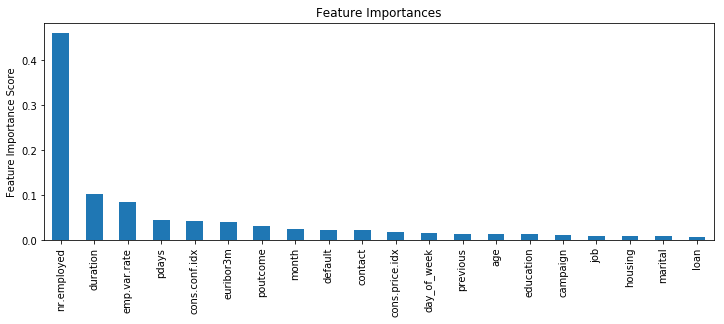

({'mean_fit_time': array([10.73973198, 10.34044027, 10.5153285 , 10.31623654,  8.79366245]),
  'mean_score_time': array([0.1360745 , 0.12589703, 0.11192465, 0.1587153 , 0.0845437 ]),
  'mean_test_score': array([0.94820852, 0.94851591, 0.9481831 , 0.94784546, 0.94758772]),
  'param_min_child_weight': masked_array(data=[4, 6, 8, 10, 12],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 4},
   {'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'rank_test_score': array([2, 1, 3, 4, 5], dtype=int32),
  'split0_test_score': array([0.94984578, 0.95024594, 0.95012335, 0.94972924, 0.94914444]),
  'split1_test_score': array([0.95391365, 0.9540535 , 0.95344569, 0.9533455 , 0.95305825]),
  'split2_test_score': array([0.9483585 , 0.94894845, 0.94845976, 0.94803018, 0.948109  ]),
  'split3_test_score': array([0.94421216, 0.9444753 , 0.94438314

In [0]:
modelfit(gsearch2b.best_estimator_, X_train, y_train)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

<font color=brown size=5>
Step 3: Tune gamma

In [0]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([10.56327543, 10.27298722, 10.1848568 , 10.18446994,  8.86337347]),
  'mean_score_time': array([0.1247963 , 0.13235979, 0.16266856, 0.12191296, 0.10551205]),
  'mean_test_score': array([0.94851591, 0.94837952, 0.94834152, 0.94846935, 0.94846046]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([1, 4, 5, 2, 3], dtype=int32),
  'split0_test_score': array([0.95024594, 0.94952795, 0.95005736, 0.95003163, 0.949702  ]),
  'split1_test_score': array([0.9540535 , 0.95410163, 0.95445275, 0.9539303 , 0.9539975 ]),
  'split2_test_score': array([0.94894845, 0.9488957 , 0.94826998, 0.9490106 , 0.94905547]),
  'split3_test_score': array([0.9444753 , 0.94434615, 0.94416789, 0.94482666, 0.94476724]),
  'split4_test_score':

<font color=green size=4>
learning rate = 0.1 <br>
n_estimators = 131 <br>
max_depth: 4 <br>
min_child_weight: 6 <br>
gamma: 0 <br>
<font color=brown size=4>
Step 4: Tune subsample and colsample_bytree


In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([ 9.49536495,  8.92591372,  8.88427324,  8.51742287, 10.06409297,
          9.8384171 ,  9.61263342,  9.36529593, 10.89021235, 10.5508872 ,
         10.22068548,  9.8869945 , 11.61067448, 11.34608374, 11.14399838,
         10.37218556]),
  'mean_score_time': array([0.11216121, 0.12290421, 0.11765943, 0.12865233, 0.11226664,
         0.13043866, 0.12369208, 0.10863619, 0.11697049, 0.12275681,
         0.13164096, 0.12512016, 0.13287234, 0.14656715, 0.12501035,
         0.0719902 ]),
  'mean_test_score': array([0.94758876, 0.94843643, 0.94871533, 0.94854228, 0.94767031,
         0.9484499 , 0.94853233, 0.94834675, 0.94797959, 0.9483568 ,
         0.94851591, 0.94845139, 0.94805575, 0.94842495, 0.94865735,
         0.94842309]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
                     0.8, 0.9, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, False,
             

<font color=green size=5>
With these two parameters, performance goes up further <br>
 {'colsample_bytree': 0.6, 'subsample': 0.8},
 0.9487153301175566) <br>
 <font color=brown size=4>
 Now we should try values in 0.05 interval around these.

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([10.43177619,  9.79118176, 10.05467925, 10.53147717, 10.34062304,
         10.21312981, 10.98388638, 10.67412987,  8.9330451 ]),
  'mean_score_time': array([0.12077637, 0.160782  , 0.12796197, 0.15877428, 0.15626335,
         0.13882985, 0.15214477, 0.13384891, 0.09227791]),
  'mean_test_score': array([0.94851073, 0.94837636, 0.94832521, 0.94833757, 0.94851591,
         0.94844867, 0.9484608 , 0.9485405 , 0.94841577]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'colsample_bytree': 0.75, '

<font color=brown size=5> 
Slight drop in the performance <br> Best parameters values for Colsample and Subsample are 0.85 and 0.8 respectively. <br>
 {'colsample_bytree': 0.85, 'subsample': 0.8},
 0.9485404983726118)

<font color=brown size=5>
Step 5: Tuning Regularization Parameters

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_


({'mean_fit_time': array([8.87744851, 8.74356298, 8.70935206, 9.02944717, 5.439223  ]),
  'mean_score_time': array([0.13423905, 0.12259059, 0.14978056, 0.14230237, 0.05829921]),
  'mean_test_score': array([0.94871527, 0.94874801, 0.94830594, 0.94866414, 0.93856827]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'rank_test_score': array([2, 1, 4, 3, 5], dtype=int32),
  'split0_test_score': array([0.95017965, 0.95039759, 0.94953824, 0.9500958 , 0.9420949 ]),
  'split1_test_score': array([0.95391123, 0.95393772, 0.95337971, 0.95402323, 0.94393481]),
  'split2_test_score': array([0.94922888, 0.94934074, 0.94840276, 0.94893602, 0.9374756 ]),
  'split3_test_score': array([0.94475936, 0.94501644, 0.94483515, 0.94487638, 0.93208629]),
 

<font color=green size=5> 
  {'reg_alpha': 0.01},
 0.9487480085416806) <br>
 <font color=brown>
 Playing around to get the optimal either side of the base line of reg_Alpha values of 0.01

In [0]:
param_test7 = {
 'reg_alpha':[0.05, 0.01, 0.15, 0.25, 0.5, 0.75, 1, 1.25, 1.35, 1.50]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=131, max_depth=5,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_


({'mean_fit_time': array([8.77399426, 8.58722701, 8.96608648, 8.77780066, 8.84143233,
         8.94411988, 8.84704728, 8.9196907 , 8.97422967, 7.27588387]),
  'mean_score_time': array([0.13470521, 0.13211164, 0.12230873, 0.12118258, 0.16365209,
         0.13125834, 0.10454707, 0.12799187, 0.11600294, 0.10861554]),
  'mean_test_score': array([0.9485383 , 0.94874801, 0.94837761, 0.94863543, 0.94847113,
         0.9486538 , 0.94866414, 0.94883653, 0.9485942 , 0.94852279]),
  'param_reg_alpha': masked_array(data=[0.05, 0.01, 0.15, 0.25, 0.5, 0.75, 1, 1.25, 1.35, 1.5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.15},
   {'reg_alpha': 0.25},
   {'reg_alpha': 0.5},
   {'reg_alpha': 0.75},
   {'reg_alpha': 1},
   {'reg_alpha': 1.25},
   {'reg_alpha': 1.35},
   {'reg_alpha': 1.5}],
  'rank_test_sco

<font color=green size=6>
reg Alpha (L1 Regularizer parameter values turns out to be 1.25 to give the highest score so far. <br>
{'reg_alpha': 1.25},
 0.948836534632432)


Model Report
Accuracy : 0.9318
AUC Score (Train): 0.962810
CV Score : Mean - 0.9488365 | Std - 0.003333791 | Min - 0.9448015 | Max - 0.9540099


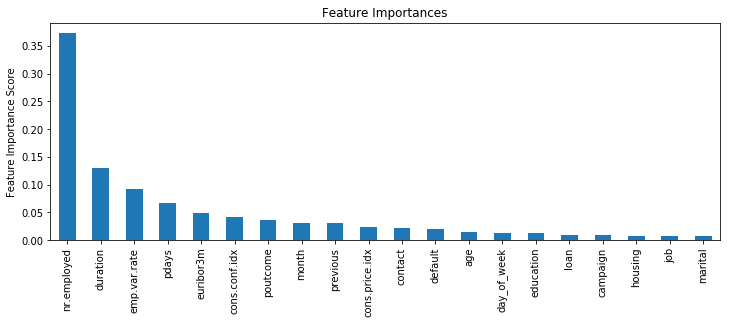

In [0]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=131,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 reg_alpha=1.25,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train)


<font color=brown size=5>
Step 6: Reducing Learning Rate


Model Report
Accuracy : 0.9326
AUC Score (Train): 0.963139
CV Score : Mean - 0.9490987 | Std - 0.003277944 | Min - 0.9451504 | Max - 0.9539899


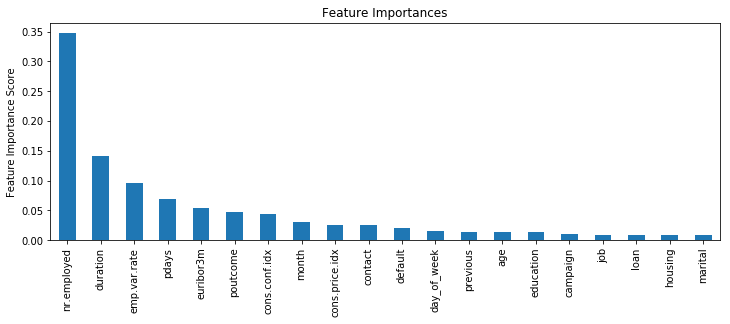

In [0]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1310,
 max_depth=5,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 reg_alpha=1.25,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, X_train, y_train)

<font color=green size=5>
Gradient Boost Mean Score is 0.9346 <br>
XGBoost Mean Score is 0.9490, which is a considerable improvement, if not substancial. <br> Little bit of Feature Engieering also happened by Feature selection and Elimination, Standardized scattering. <br> Additionally, we could use Ensemble of models, stacking for further improvement. 